# The Traveling Salesman Problem: National Parks Edition
#### Naomi Dailey | ABT 182 Final Project



## Overview

The Traveling Salesman Problem (TSP) is one of the most famous problems in computer science. It analyzes the age-old question of determining optimal spatial paths between many locations (Hoffman et al., 2013). Specifically, the TSP asks: 

> Given a list of points and the distances between them, what is the shortest path that visits each city once and returns to the origin?

The TSP is based on the historical traveling salesman of [Willy Loman](https://en.wikipedia.org/wiki/Willy_Loman) fame. Individuals traveled door-to-door, enticing residents to purchase Cutco knives, Tupperware, vaccuums, and the like. Salesmen like Willy had to carefully plan an efficient route from city to city--the shorter the route the better. 

This conundrum seduced computer scientists because of how computationally expensive it can be. To search for the optimal path for all possibilities among *n* points is more difficult the more points you have. In computer science, this is known as an O(n!) (or 'Big O') notation algorithm (Google Developers, 2015). Thus, an automation problem was born.

## Problem

Instead of the shortest distance between cities, this project will enable the user to find the shortest distances between any points with longitude and latitude values. In the example presented here, I use coordinates for U.S. National Parks scraped from [Wikipedia](https://en.wikipedia.org/wiki/List_of_areas_in_the_United_States_National_Park_System#National_parks), but you could substitute these with any web scraped points. Alternatively, you could skip the web scraping and provide a .csv with your points.

You may be thinking, *doesn't [Google Maps](https://developers.google.com/maps/documentation/directions/) already do this?* The answer is yes, but only to a point (haha). Google Maps Directions API provides superb applications for  paths between [waypoints](https://developers.google.com/maps/documentation/directions/intro#Waypoints), but limits the user to 23 such points. This leaves much to be desired if you have a long list of destinations you want to hit, like my epic National Park road trip. By inputting user-specified points with associated coordinate values, this project returns the optimal itinerant route via Euclidean distance, with possible expansion to driving distance and time (in progress).

## Concepts

While the TSP is relatively easy to describe, it remains a delightful thought experiment because it is so computationally expensive to solve. Hoffman et al. (2013) describe the TSP as part of a larger group of problems that are known as [combinatorial optimization problems](https://en.wikipedia.org/wiki/Combinatorial_optimization). Specifically, the TSP is classified as *NP*-complete, meaning that if someone could write an efficient algorithm for the TSP, then all other *NP*-complete problems could also be solved with similarly efficient solutions (Hoffman et al., 2013).

#### Brute Force

To solve an *NP*-complete problem by brute force isn't really feasible. [Mihailo Lalevic](http://www.digitalmihailo.com/traveling-salesman-problem-dynamic-algorithm-implementation-in-python/) wrote a Python script that shows the relationship between number of points and processing time; when you reach 22 points, the performance declines immensely because of memory usage (and takes over 10 minutes!). If I were to try to solve my National Parks problem by brute force, the number of permutations of possible routes is staggering: 

In [1]:
import math
math.factorial(44)

2658271574788448768043625811014615890319638528000000000

That's a lot of potential routes. So maybe brute force is not the best solution for my road trip--I'd like to spend more time travelling than actually planning my excursion!

#### Christofides Algorithm

Fortunately, others have created computer programs and algorithms to make the TSP easy for amateurs like myself. Many solutions to the TSP reference [Christofides algorithm](https://en.wikipedia.org/wiki/Christofides_algorithm) (1976), which finds approximate solutions to the TSP based on instances where distances are symmetric and obey the triangle equality concept. This algorithm guarantees that its solutions will be within a factor of 1.5 of the optimal solution length.



#### Traveling Telsa Salesman

Mortada Meyhar found that the [Concorde computer program](http://www.math.uwaterloo.ca/tsp/concorde.html) for the TSP (Version 3.12.19, University of Waterloo) could find the exact optimal path between Tesla supercharger stations, without approximation. Concorde does this using branch-and-bound algorithms: "when the algorithm branches out to search for the optimum, many of the permutations can actually be safely cut short if it is impossible for a branch to result in a value better than a known better solution" (Mehyar, 2015). Mehyar has created a helpful example of the optimal driving path between [Tesla supercharger stations](http://mortada.net/the-traveling-tesla-salesman.html#Optimal-Path-for-Supercharger-Traveling), built with the Google Maps Directions API.

# Solving the TSP
I'll be emulating Meyhar's method to find the optimum path (as the crow flies) through my National Park coordinates. Below I'll go through each step, provide the code and outputs, and do my best to make the script as generalizable as possible. Please note that this markdown file and the script were written using the [iPython Notebook](https://ipython.org), so there are some weird magic commands at the top of some of the cells. Other tools I used to solve the TSP and create web maps included:
* [Concorde](http://www.math.uwaterloo.ca/tsp/concorde/index.html) (Mac installations [here](http://wiki.evilmadscientist.com/Obtaining_a_TSP_solver))
* [QSOPT](http://www.math.uwaterloo.ca/~bico/qsopt/) (Mac installations [here](http://www.math.uwaterloo.ca/~bico//qsopt/beta/index.html))
* [Leaflet](http://leafletjs.com) (Install directions [here](http://leafletjs.com/download.html))
* Command line (Great tutorial [here](https://www.codecademy.com/learn/learn-the-command-line))
* Text editor (I used [TextWrangler](https://itunes.apple.com/us/app/textwrangler/id404010395?mt=12) for web map HTML editing, but any will do)

## Set-Up
This project was written in Python 3.5, which may cause problems if you are running other versions (modules like numpy and pandas are version-specific). Below are the modules necessary to complete this script, as well as a simple folder structure to organize the project. Please note that some of the modules (e.g., `pandas` and `numpy`) require command line installation using  `pip install`. Please place the `Dailey_FinalProject` folder on your desktop so the working directory is defined correctly.

In [1]:
%matplotlib inline
import bs4, re, requests, json, os, csv
import matplotlib.pyplot as plt
import numpy as npy
import pandas as pd
from geojson import Feature, Point, FeatureCollection, LineString
from shapely.geometry import Point, mapping

Failed `CDLL(/opt/local/lib/libgeos_c.dylib)`


In [2]:
# set working directory and results path to '/Dailey_FinalProject'
path = os.path.join(os.getcwd(), "Desktop/Dailey_FinalProject")
outpath = os.path.join(path, "Results")
if not os.path.exists(outpath): os.mkdir(outpath)

# moves the map .html document into your results folder
map_oldpath = os.path.join(path, "TSP_webmap.html")
map_newpath = os.path.join(outpath, "TSP_webmap.html")
os.rename(map_oldpath, map_newpath)

## Getting Latitude + Longitude
There are two options here for getting the latitude and longitude inputs: web scraping or importing .csv files. First, I'll go through the process of web scraping, which is of particular interest to me. Second, I will provide a way for the user to import her own .csv file as a dictionary of coordinate pairs. 

### Option 1: Web Scraping

Before this project, web scraping data was a mystery to me, fit only for the most talented programmers. Enter: BeautifulSoup. This is a fantastic web scraping library that makes it easy to identify and parse your data from HTML source code. Note that for Mac, I had to enable the [Safari Web Inspector](https://developer.apple.com/library/safari/documentation/AppleApplications/Conceptual/Safari_Developer_Guide/Introduction/Introduction.html) to access the source code for a web page. I did have to scour the source code for tags that matched the coordinates I wanted, but the Web Inspector made it easy to identify which HTML tags to look for.

For the record, your method of web scraping will change depending on the website you visit. Wikipedia HTML *tends* to be structured similarly between pages, but the tags you use and geospatial format of your points will change depending on the web page. For example, I can easily fetch latitude and longitude coordinates for the [tallest peaks](https://en.wikipedia.org/wiki/List_of_the_highest_major_summits_of_the_United_States) in the U.S. using the method outlined below, but if I want to scrape [Peet's street addresses](http://www.peets.com/stores/peets-stores/stores-store-list.html) for a cup of coffee, the tags and geocoding will be different. (Note that some of the modules below require installation from the Terminal.)

Getting the URL (and the source code) you want is a relatively simple affair. Getting the right spatial reference for your points (e.g., coordinates, addresses) is a different matter. Here I used the Wikipedia page for U.S. National Parks, imported the source code as text, and created a BeautifulSoup object that I can use to search for the information I want.

In [3]:
def webScrapeAllHTML(myURL):
    page = requests.get(myURL)
    # imports the source code as text
    content = page.text 
    # create BeautifulSoup object to search the text by tags
    return (bs4.BeautifulSoup(content, 'lxml'))

# fetch URL from Wikipedia National Parks website
parks_url = 'https://en.wikipedia.org/wiki/List_of_national_parks_of_the_United_States'
soup = webScrapeAllHTML(parks_url)

The output from BeautifulSoup needs additional processing before I can continue solving the TSP. Next, I identified the coordinates from this BeautifulSoup object using tags found in the HTML source code. This required some tedious reading of HTML script to find the tags associated with the data I wanted. Finding the tags that identify each coordinate pair is an onerous task, but extracting the coordinates and appending them to a list requires a regular `for` loop. As you can see below, I put the coordinates in a list to easily form a dictionary object later.

In [4]:
# identify coordinates using the tags in the webScrapeAllHTML() output
html_coords = soup.find_all("span", "geo")

# extract coordinates from soup and cast to list
coords = []
for tag in html_coords:
    lat, lon = tag.text.strip().split(';') # pulls coordinates out
    lat, lon = float(lat), float(lon) # reformat to floats
    latlon = [lat, lon]
    coords.append(latlon) # create list of lat lon values

Now that I have a list of latitude and longitude values, I can extract the corresponding National Park names for each coordinate pair. Here I've used the same methods as above, but with different HTML tags to extract names and create a list. I'll combine the names and coordinates in a dictionary later on.

In [5]:
# same as above, but identify names using tags in webScrapeAllHTML() output
html_names = soup.find_all('th', attrs = {'scope':'row'})

# extract names from soup and cast to list
names = []
for name in html_names:
    extract = name.text.strip()
    names.append(extract)

### Option 2: Importing CSV Files

If the user desires, they can also use a .csv for this process. I've included a sample .csv in the `Dailey_FinalProject` folder to test this. A .csv allows for more flexibility in terms of data entry, and different types of points can be used (e.g., a mix of restaurants and coffee shops instead of only national parks). However, the script below assumes that the .csv file is in the following format: 

|Name | Latitude | Longitude|
|---- | -------- | ---------|
|Yosemite | 37.51  | -119.33|
|Zion | 37.12  | -112.59|

In [6]:
# operates under assumption that  sammple.csv is in the current working directory (path)
mycsv = 'sample.csv'
newcsv = 'sample_new.csv'
csvpath = os.path.join(path, mycsv) # set path to user's .csv

with open(csvpath, mode = 'r') as infile:
    reader = csv.reader(infile) # read the user's .csv
    with open(newcsv, mode = 'w') as outfile:
        writer = csv.writer(outfile)
        # compile .csv rows into dictionary using dictionary comprehension
        mydict = {rows[0]: [float(rows[1]), float(rows[2])] for rows in reader} 
print(mydict.keys())

# the resulting dictionary can now be used for the rest of the script below

dict_keys(['Badlands', 'Yosemite', 'Zion', 'Arches', 'Acadia'])


## Data Formatting

Now that I have a list of coordinates and a list of park names, I need to combine it in a format that is easy to reference. If you're familiar with [R](https://www.r-project.org), I was going for a data frame type of object. Fortunately, the [pandas](http://pandas.pydata.org) library is a great substitute for building and manipulating data frames. 

### Create Dictionary

*NOTE: If you used the .csv option to import your data, you can skip this step!*

First, I put the names and coordinates into a dictionary. This made it easier to eliminate parks that were not in the contiguous United States (which would make my road trip a bit more difficult). Using the dictionary, I was able to make a rough bounding box with longitude values to limit my parks. For National Parks that still fall within the longitude range, but are not in the contiguous U.S., I had to do a manual delete (e.g., Channel Islands and Dry Tortugas). 

In [7]:
# NOTE: if you are using Option 2 (.csv method above) skip this step
# make a dictionary of names with associated coordinates
NPdict = dict(zip(names, coords))

# identify parks outside of contiguous US
keys_to_remove = []

# NOTE: the following 2 loops are not combined because we cannot change the size of the dictionary while iterating
for key in NPdict.keys():
    if (NPdict[key][1] < -130 or NPdict[key][1] > -65):
        keys_to_remove.append(key) # append those identified parks into a list

# delete unwanted parks that lie outside of contiguous US
for key in keys_to_remove:
    NPdict.pop(key, None)

# delete stragglers (island parks that fall within the bounding box)
del NPdict['Channel Islands']
del NPdict['Dry Tortugas']

### Create Data Frame with `pandas` 

Finally, I made a nicely formatted data frame for our viewing pleasure. Coordinates are indexed by the National Park name, and sorted into latitude and longitude columns. If you imported your data with the .csv option, simply replace `NPdict` in the first line with the name of your dictionary `mydict`.

In [8]:
# make data frame from dictionary
dataframe = pd.DataFrame.from_dict(NPdict).T
dataframe.columns = ['Lat', 'Lon']
dataframe.head()

,Lat,Lon
Acadia,44.35,-68.21
Arches,38.68,-109.57
Badlands,43.75,-102.50
Big Bend,29.25,-103.25
Biscayne,25.65,-80.08


## Computing Distances

### Write Distance Function

Computing geodesic distances on Earth's surface is easy enough, especially because [John D. Cook](http://www.johndcook.com/blog/python_longitude_latitude/) wrote such a clear Python script on how to do it. This function replicated from his blog. This function will calculate the distance between Point 1 and Point 2 on the surface of the earth, defined by the points' latitude and longitude. Rather than calculating distance on a flat plane, this function computes spherical distances from the converted coordinates, giving us a more accurate represetation of distances.

In [9]:
# calculate geodesic distances for any set of lat lon values you have
# NOTE: this calculates Euclidean distance, not driving distance!!
def earthDistance(lat1, lon1, lat2, lon2, radius = 6378.388, unit_miles = False):

    """
    This equation computes distances between two points on Earth's surface specified by lat and lon.
    Assume Earth to be a perfect sphere with a given radius (default is 6378.388 km).
    Function can output miles or km (default is km).
    
    Reference
    ---------
    Adopted from John D. Cook's blog post: http://www.johndcook.com/blog/python_longitude_latitude/
    and from Mortada Mehyar's blog post: http://mortada.net/the-traveling-tesla-salesman.html
    """
    
    # convert lat and lon to spherical coordinates in radians
    deg_to_rad = npy.pi / 180.0
    
    # phi = 90 - lat
    phi1 = (90.0 - lat1) * deg_to_rad
    phi2 = (90.0 - lat2) * deg_to_rad
    
    # theta = longitude
    theta1 = lon1 * deg_to_rad
    theta2 = lon2 * deg_to_rad
    
    # compute spherical distance from converted coordinates
    cos = (npy.sin(phi1) * npy.sin(phi2) * npy.cos(theta1 - theta2) + npy.cos(phi1) * npy.cos(phi2))
    arc = npy.arccos(cos)
    length = arc * radius
    
    if (unit_miles == True):
        length = length/1.60934
    
    return length

### Calulate Distances

I can now use this function to calculate distances between each National Park. The function will step through a list of National Park names, match the name to the dataframe with latitude and longitude values, and calculate the distances. For example, it will begin with the first park (e.g., Acadia) and calculate the distances between Acadia and all other 43 parks. Next, it will then move onto the second park (e.g., Arches) and calculate the distances between Arches and all other 43 parks. And so on, until the end of the list is reached.

In [10]:
# make list of park names from dictionary to use in distance calculation
dictnames = list(NPdict.keys())
distances = {}

# calculate distances between each national park
for i in range(len(dictnames)): 
    
    # start point
    start = dictnames[i]
    distances[start] = {}
    
    for j in range(len(dictnames)):
        
        # stop point
        stop = dictnames[j]
        
        # the distance is 0 from a point to itself
        if j == i:
            distances[start][stop] = 0.
            
        # if the names are different, then the earthDistance() function is used
        elif j > i:
            
            # list names are used to index the lat lon values from the data frame
            distances[start][stop] = earthDistance(dataframe.ix[start, 'Lat'], dataframe.ix[start, 'Lon'], dataframe.ix[stop, 'Lat'], dataframe.ix[stop, 'Lon'], unit_miles = True)
        
        # ensures you don't compute the same distances twice
        else:
            distances[start][stop] = distances[stop][start]

### Data Visualization

Now that I've calculated distances between each National Park, it would be nice to get a sense of what that data looks like before proceeding. The `pandas` dataframe is a great way to check out some of the values, and determine if the results are what I would expect. I can see below that Arches National Park is only 161.4439 miles from Bryce Canyon National Park, which is logical given that they are both in Utah. 

In [11]:
# save distances to new dataframe and view values (in miles)
distances = pd.DataFrame(distances)
distances.head()

,Acadia,Arches,Badlands,Big Bend,Biscayne,Black Canyon of the Gunnison,Bryce Canyon,Canyonlands,Capitol Reef,Carlsbad Caverns,...,Rocky Mountain,Saguaro,Sequoia,Shenandoah,Theodore Roosevelt,Voyageurs,Wind Cave,Yellowstone,Yosemite,Zion
Acadia,0.000000,2154.344980,1692.786260,2180.863111,1454.348997,2066.097994,2315.490775,2185.810886,2247.004293,2118.939749,...,1912.270301,2412.494592,2671.414581,661.403350,1698.848031,1205.079631,1743.383057,2063.637648,2667.388082,2366.624788
Arches,2154.344980,0.000000,507.911668,745.807969,1935.748550,100.264670,161.443975,38.508500,92.828905,534.939683,...,243.808027,447.853734,522.991329,1679.419627,651.617660,1073.279068,463.547120,412.311904,542.315806,212.359977
Badlands,1692.786260,507.911668,0.000000,1003.871836,1775.768221,449.564958,663.098903,545.424276,593.062825,807.921073,...,280.502668,906.117156,992.171160,1303.594794,227.469704,565.600159,50.598301,401.061475,977.547710,710.900705
Big Bend,2180.863111,745.807969,1003.871836,0.000000,1441.467071,693.638113,771.928947,728.172291,767.999559,214.021594,...,782.464559,478.198026,1023.266146,1560.682947,1225.803756,1440.818576,990.647833,1133.802009,1106.546397,793.627257
Biscayne,1454.348997,1935.748550,1775.768221,1441.467071,0.000000,1839.158258,2049.861574,1943.816353,2008.254237,1538.503160,...,1786.020386,1890.139558,2388.139287,896.653423,1952.400765,1725.839127,1807.752143,2142.267314,2446.074127,2091.859813


Some graphs would also be useful in understanding the distribution of distances between parks. Using the matplotlib library, I can create some histograms that show me the distribution of closest and furthest National Parks from each other. While this isn't really necessary for figuring out the shortest route between parks, it is nice to check the distribution of the data and make sure there aren't outliers I missed.

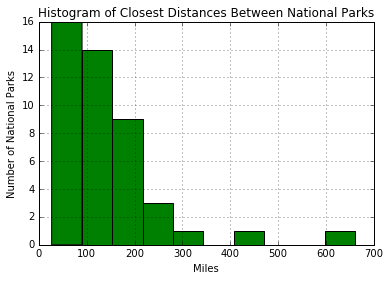

In [12]:
# data visualization of distance results
closestNP = distances[distances > 0].min()
cnp = closestNP.hist(bins = 10, color = 'green') # set bins
cnp.set_title('Histogram of Closest Distances Between National Parks') # set labels
cnp.set_ylabel('Number of National Parks')
cnp.set_xlabel('Miles')

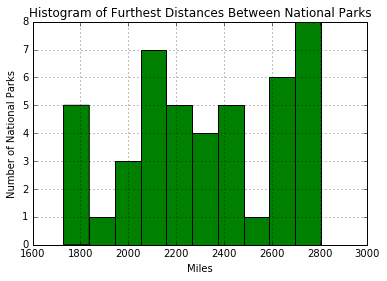

In [13]:
furthestNP = distances[distances > 0].max()
fnp = furthestNP.hist(bins = 10, color = 'green')
fnp.set_title('Histogram of Furthest Distances Between National Parks')
fnp.set_ylabel('Number of National Parks')
fnp.set_xlabel('Miles')

## Finding the Optimal Path

Here's the tricky part when the code is no longer, er, _technically_ reproducible. We are now ready to write our points to a file that can be used by the [Concorde](http://www.math.uwaterloo.ca/tsp/concorde.html) TSP Solver. Recall that installing the program required some command line work, and also requires that you have a working C compiler. Before using Concorde, I had to install [Xcode](https://itunes.apple.com/us/app/xcode/id497799835?mt=12) for Mac and ensure that the command line tools package was downloaded. 

All that said, not everyone will have (or want to install) Concorde. Therefore, I've also included a Python script from Mihalo Lalevic's website that solves the TSP with a restricted number of points. Option 1 is the Concorde method, and Option 2 is the brute force method.

### Concorde TSP Solver

#### Write .tsp File

The code below outlines the file format used by Concorde. I first iterate through the list of national park names, matching names to corresponding coordinates that get assigned a unique ID number. This output is the `NODE_COORD_SECTION` of the file, and the number of nodes is the `DIMENSION` of the file. The resulting .tsp file is saved in my current directory.

In [14]:
# NOTE: before running this section, must install QSOPT + Concorde (see: '/Dailey_FinalProject/README.pdf')
# write the coordinate values to a .tsp file to use in Concorde
node_id = 0
output = ''

# iterate over park names to make an array of ID, latitude and longitude values
for name in dictnames:
    output += '%d %f %f\n' % (node_id, dataframe.ix[name, 'Lat'], dataframe.ix[name, 'Lon'])
    node_id += 1

# format for .tsp file
header = """NAME : NP TSP
COMMENT : National Park TSP
TYPE : TSP
DIMENSION : %d
EDGE_WEIGHT_TYPE : GEOM
NODE_COORD_SECTION 
""" % (node_id)

# compile results into .tsp file
tspfile = os.path.join(outpath, 'nationalparks.tsp')
with open(tspfile, 'w') as output_file:
    output_file.write(header)
    output_file.write(output)

#### Run Concorde

[This](http://davidsjohnson.net/TSPcourse/mac-install-concorde.txt) was a great set-up tutorial for Concorde in the terminal. To use the .tsp file I've created above with Concorde, use this code on the command line, inputting your name for `<name>` (on Mac OS):
> Change the directory to the Concorde TSP folder:

>`cd /Users/<name>/Desktop/Dailey_FinalProject/concorde/TSP`

> Execute the Concorde program with the full path to the .tsp file:

>`./concorde /Users/<name>/Desktop/Dailey_FinalProject/Results/nationalparks.tsp`

#### Parse .sol File

After running Concorde, a result appears in the Terminal and the corresponding .sol result file is saved to the current directory (in this case, the Concorde/TSP folder). In order to see the results, the .sol file must be parsed and read in Python. 

In [15]:
# import the Concorde .sol file
solution_file = os.path.join(path, 'concorde/TSP/nationalparks.sol')

# parse the .sol file to get solutions
# solutions are a list of ID's that correspond to the order of national parks you would visit
solution = []
f = open(solution_file, 'r')
for line in f.readlines():
    tokens = line.split()
    solution += [int(c) for c in tokens] 
f.close()

# ensure the solution length is the same as the park names list length
assert solution[0] == len(dictnames)

# first number in solution is just the dimension (# of nodes), don't need it
solution = solution[1:] 

# check that lengths are the same
assert len(solution) == len(dictnames)

Now that the solutions have been parsed, I can match the unique ID's for each national park to its corresponding name. Then, I append the solutions into a list and check out the order of national parks I will be visiting! Below, I also double check that I am starting and stopping at the same national park, by changing the list into a `Series` and checking the `head()` and `tail()`. 

In [16]:
# append solutions into a list
optimal_path = []
for solution_id in solution:
    optimal_path.append(dictnames[solution_id])
    
# make sure the path starts and ends at the same national park
optimal_path.append(dictnames[solution[0]])

# reformat into a series for cleaner visualization
optimal_path_series = pd.Series(optimal_path)

# check that the first and last national parks are the same
optimal_path_series.head()

0            Sequoia
1          Pinnacles
2           Yosemite
3    Lassen Volcanic
4            Redwood
dtype: object

In [17]:
optimal_path_series.tail()

41    Grand Canyon
42     Joshua Tree
43    Death Valley
44    Kings Canyon
45         Sequoia
dtype: object

### Calculate Total TSP Distance

I can also calculate the total distance of my road trip (except that this is Euclidean distance, so it would actually be my flight path between national parks). To do highway distances is a whole other bag of tricks that I am not able to do yet...

In [18]:
# find the total distance of the optimal path
total_dist = 0
for i in range(len(optimal_path) - 1):
    total_dist += distances.ix[optimal_path[i], optimal_path[i + 1]]
total_dist

# total distance should be 10959.222 miles

10959.222975372008

# Web Mapping

I successfully found the most efficient route (based on Euclidean distance) and found how many miles my trip will be! The next step is to view the trip on a map. I decided to use [Leaflet](http://leafletjs.com) because I dig open source and have wanted to learn how to use it. Leaflet also enables you to use [background maps](https://leaflet-extras.github.io/leaflet-providers/preview/index.html) from the awesome cartographers at [Stamen](http://stamen.com), [OpenStreetMap](https://www.openstreetmap.org/#map=5/37.996/-100.876), and others. I found it easier to use and easier to manipulate than the Google Maps Directions API. Personal preference.

## Leaflet

Leaflet uses JavaScript to create and manipulate web maps. While I am no JS expert, I worked on the [Codecademy](https://www.codecademy.com/learn/javascript) tutorial for JS and was able to write a script that displays my map. Before writing the Leaflet script, however, I have to put the ordered national park names and their coordinates into a list that can be used in JS. It's important that my TSP solution is in a list, so that the order does not change! 

## Writing to GeoJSON

There are some very helpful tools out there to write a GeoJSON file from a Python dictionary. I created the `tsp_point.json` and the `tsp_line.json` files in two different ways: 

* A `for` loop, which is great for specific manipulation of properties
* Or using the `geojson` Python module, which is a great quick and dirty version 

### `for` loop

To structure the `for` loop, I used this [this](http://thirdlanding.com/using-python-to-create-a-geojson-file-from-a-database-containing-lats-and-longs/) script as a template. It helped structure my Python list of coordinates into a nicely formatted FeatureCollection GeoJSON file. I found it easier to manipulate the properties of my .json file using this method, which produced nice pop-ups in the final map.

In [19]:
# extract coordinates and names from the pandas dataframe
TSP_coords = []
for name in optimal_path:
    TSP_coords += [[dataframe.ix[name, 'Lon'], dataframe.ix[name, 'Lat'], name]]

#gjson will be the main dictionary converted to .json format
gjsonpoint_dict = {}
gjsonpoint_dict["type"] = "FeatureCollection"
feat_list = []

# loop through all points, building a list entry which is a dictionary
for coords in TSP_coords:
    # each of these dictionaries has within it nested a type dict, 
    # which contains a point dict and properties dict
    type_dict = {}
    point_dict = {}
    prop_dict = {}
    
    type_dict["type"] = "Feature"
    point_dict["type"] = "Point"
    type_dict["geometry"] = mapping(Point(coords[0],coords[1]))
    
    prop_dict["Name"] = coords[2]
    type_dict["properties"] = prop_dict
    feat_list.append(type_dict)
    
gjsonpoint_dict["features"] = feat_list

# write the resulting dictionary to a .json file that outputs in the Results folder
points_path = os.path.join(outpath, 'tsp_point.json')
with open(points_path, 'w') as outfile:
    json.dump(gjsonpoint_dict, outfile, sort_keys = True, indent = 4, ensure_ascii = False)  

### `geojson` module

Using the `geojson` module was even easier, and only required me to input the coordinates as a list of tuples before writing the file. The code is much shorter, but was more difficult to manipulate if I needed to change properties or types of elements within the .json file.

In [20]:
# extract only coordinates as list of tuples from the pandas dataframe
coordinates = []
for name in optimal_path:
    coordinates += [(dataframe.ix[name, 'Lon'], dataframe.ix[name, 'Lat'])]

# use geojson LineString method to create .json polyline file
gjsonline_dict = LineString(coordinates)

# as above, write the result to a .json file that outputs in the Results folder
line_path = os.path.join(outpath, 'tsp_line.json')
with open(line_path, 'w') as outfile:
    json.dump(gjsonline_dict, outfile, sort_keys = True, indent = 4, ensure_ascii = False)

# Final Map

If you've run everything above, you should see the following file structure in the `Dailey_FinalProject/Results` folder:

> `nationalparks.tsp`

> `TSP_LeafletMap.html`

> `tsp_line.json`

> `tsp_point.json`

If you double click on the `TSP_LeafletMap.html`, a web map will open with the final result with the Euclidean distance map. It should look exactly like the image below.

Congratulations! You solved the Traveling Salesman Problem!